In [1]:
pip install xgboost

     |████████████████████████████████| 173.6 MB 8.2 kB/s             
Note: you may need to restart the kernel to use updated packages.


In [9]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE, RFECV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'Chapter4/insurance.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading the csv file
insurance = pd.read_csv(file_content_stream)
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [10]:
## Changing labels to numbers 
insurance['sex'] = np.where(insurance['sex'] == 'female', 0, 1)
insurance['smoker'] = np.where(insurance['smoker'] == 'no', 0, 1)

## Extracting region dummies
region_dummies = pd.get_dummies(insurance['region']).iloc[:, 0:3]

## Appending dummies 
insurance = pd.concat([insurance, region_dummies], axis = 1)

insurance.head()

,age,sex,bmi,children,smoker,region,charges,northeast,northwest,southeast
0,19,0,27.900,0,1,southwest,16884.92400,0,0,0
1,18,1,33.770,1,0,southeast,1725.55230,0,0,1
2,28,1,33.000,3,0,southeast,4449.46200,0,0,1
3,33,1,22.705,0,0,northwest,21984.47061,0,1,0
4,32,1,28.880,0,0,northwest,3866.85520,0,1,0


[Text(697.5, 713.475, 'smoker <= 0.5\nmse = 144629749.291\nsamples = 1070\nvalue = 13323.617'),
 Text(348.75, 509.625, 'age <= 42.5\nmse = 36410325.435\nsamples = 849\nvalue = 8514.701'),
 Text(174.375, 305.775, 'children <= 0.5\nmse = 23506425.809\nsamples = 472\nvalue = 5475.106'),
 Text(87.1875, 101.92499999999995, 'mse = 17173285.971\nsamples = 198\nvalue = 3821.2'),
 Text(261.5625, 101.92499999999995, 'mse = 24677845.488\nsamples = 274\nvalue = 6670.264'),
 Text(523.125, 305.775, 'age <= 51.5\nmse = 26516423.292\nsamples = 377\nvalue = 12320.242'),
 Text(435.9375, 101.92499999999995, 'mse = 20947388.493\nsamples = 162\nvalue = 10226.229'),
 Text(610.3125, 101.92499999999995, 'mse = 24919163.638\nsamples = 215\nvalue = 13898.057'),
 Text(1046.25, 509.625, 'bmi <= 30.01\nmse = 130237181.501\nsamples = 221\nvalue = 31797.685'),
 Text(871.875, 305.775, 'age <= 39.5\nmse = 26922886.895\nsamples = 107\nvalue = 21466.479'),
 Text(784.6875, 101.92499999999995, 'mse = 12486996.214\nsamples

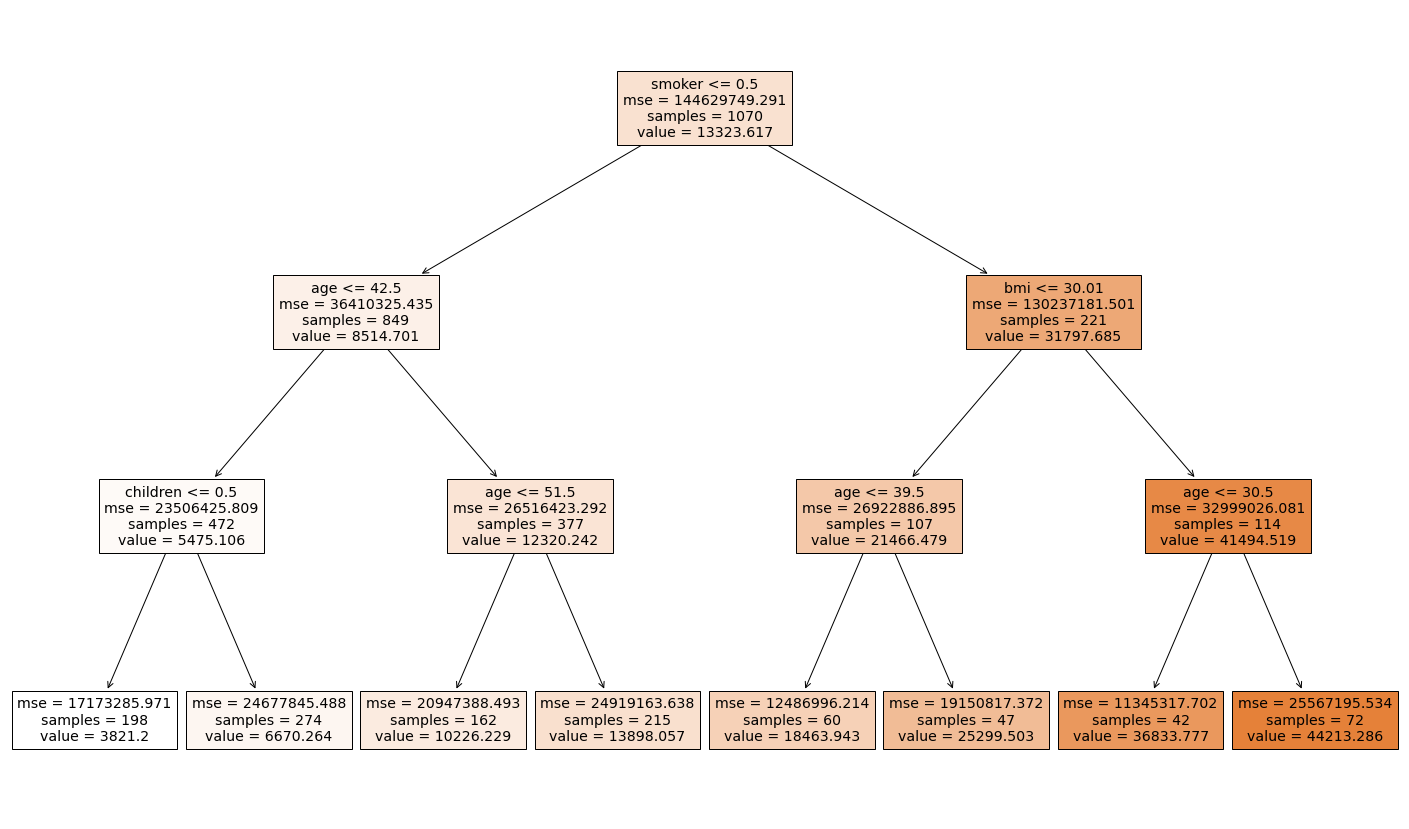

In [11]:
## Defining the input and target variables
X = insurance.drop(columns = ['charges', 'region'], axis = 1)
Y = insurance['charges']

## Spliting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

## Building the decision tree on the train data-frame
tree_md = DecisionTreeRegressor(max_depth = 3).fit(X_train, Y_train)

## Visualizing the decision-tree model 
fig = plt.figure(figsize = (25, 15))
plot_tree(tree_md, feature_names = X_train.columns, filled = True)

In [12]:
## Forcing to be data-frames
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

## Engineering features from decision-tree
X_train['interaction_1'] = np.where((X_train['smoker'] == 0) & (X_train['age'] <= 32.5), 1, 0)
X_train['interaction_2'] = np.where((X_train['smoker'] == 0) & (X_train['age'] > 32.5) & (X_train['age'] <= 44.5), 1, 0)
X_train['interaction_3'] = np.where((X_train['smoker'] == 0) & (X_train['age'] > 44.5) & (X_train['age'] < 51.5), 1, 0)
X_train['interaction_4'] = np.where((X_train['smoker'] == 0) & (X_train['age'] > 51.5), 1, 0)

X_test['interaction_1'] = np.where((X_test['smoker'] == 0) & (X_test['age'] <= 32.5), 1, 0)
X_test['interaction_2'] = np.where((X_test['smoker'] == 0) & (X_test['age'] > 32.5) & (X_test['age'] <= 44.5), 1, 0)
X_test['interaction_3'] = np.where((X_test['smoker'] == 0) & (X_test['age'] > 44.5) & (X_test['age'] < 51.5), 1, 0)
X_test['interaction_4'] = np.where((X_test['smoker'] == 0) & (X_test['age'] > 51.5), 1, 0)

In [6]:
## Fitting random forest model 
RF = RandomForestRegressor(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

## Predicting on the test
RF_pred = RF.predict(X_test)

## Computing the mse
print(mean_squared_error(Y_test, RF_pred))

24221129.323697325


In [6]:
## Fitting the xgboost model 
xgb = XGBRegressor(booster = 'gbtree', objective = 'reg:squarederror', n_estimators = 500, max_depth = 3, learning_rate = 0.01, n_jobs = -1).fit(X_train, Y_train)

## Predicting on the test 
xgb_pred = xgb.predict(X_test)

## Computing the mse
print(mean_squared_error(Y_test, xgb_pred))

19861172.162306346


## Feature Selection

In [16]:
## Running RFE with Random forest
RF_auto_feature = RFECV(estimator = RandomForestRegressor(n_estimators = 500, max_depth = 3), step = 1, min_features_to_select = 2, cv = 3).fit(X_train, Y_train)

## Identifying important features 
print(X_train.columns[RF_auto_feature.support_])

Index(['age', 'bmi', 'children', 'smoker', 'interaction_3', 'interaction_4'], dtype='object')


In [17]:
RF_auto_feature.ranking_

array([1, 7, 1, 1, 1, 6, 5, 4, 2, 3, 1, 1])

## Hyper-Parameter Tuning

In [ ]:
## Selecting top 5 variables
X_train = X_train[['age', 'children', 'smoker', 'interaction_3', 'interaction_4']]
X_test = X_test[['age', 'children', 'smoker', 'interaction_3', 'interaction_4']]


## Defining the hyper-parameter grid
XGBoost_param_grid = {'objetive': ['reg:squarederror'],
                      'n_estimators': [100, 300, 500],
                      'max_depth': [3, 5, 7],
                      'min_child_weight': [5, 7, 10],
                      'learning_rate': [0.001, 0.01, 0.1],
                      'gamma': [0.5, 0.3, 0.1, 0.01, 0.001],
                      'subsample': [0.7, 0.8, 0.9, 1],
                      'colsample_bytree': [0.7, 0.8, 0.9, 1]}

## Performing grid search with 5 folds
XGBoost_grid_search = GridSearchCV(XGBRegressor(), XGBoost_param_grid, cv = 5, scoring = 'neg_mean_squared_error').fit(X_train, Y_train)

## Extracting the best model 
XGBoost_grid_search.best_params_

[13:52:15] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:52:15] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:52:16] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but gett